In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [4]:
# training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=8192, shuffle=True, pin_memory=False)


In [5]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

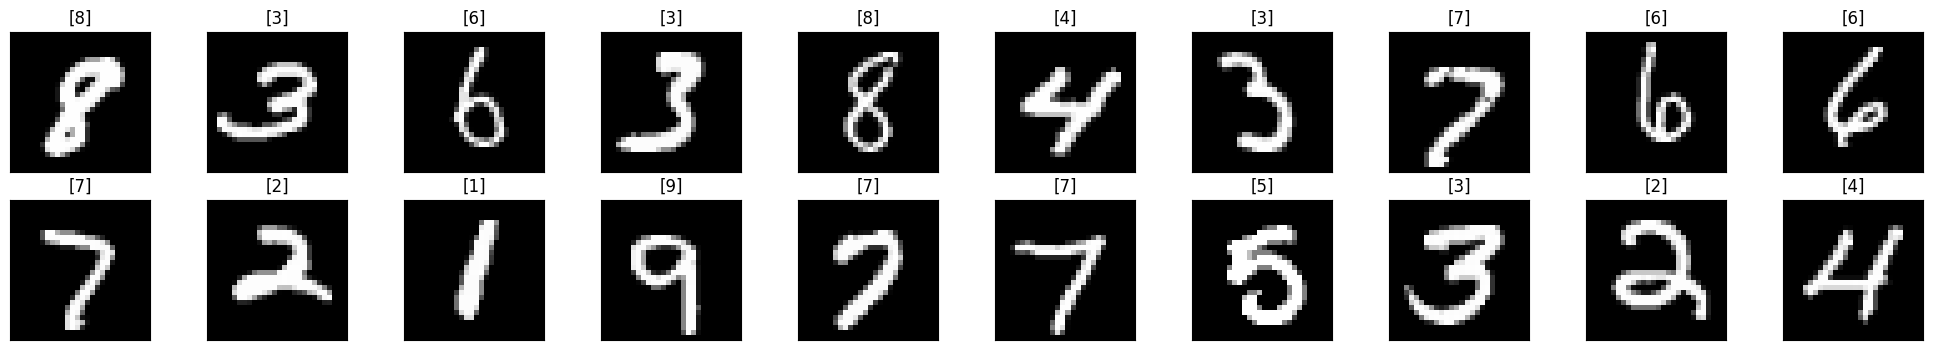

In [6]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [7]:
 class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [8]:
model = Classifier(784, 125, 65, 10).to(device)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
epochs = 12
running_loss_history = []
running_corrects_history = []
for e in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in training_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.reshape(inputs.shape[0], -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

        running_loss += loss.item()
    else:
        epoch_loss = running_loss / len(training_loader)
        epoch_accuracy = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        print('training loss:{:.4f}, {:.4f}'.format(epoch_loss, epoch_accuracy.item()))

training loss:2.3743, 1662.1250
training loss:1.3202, 4241.0000
training loss:0.6712, 5935.5000
training loss:0.4999, 6389.5000
training loss:0.4151, 6583.1250
training loss:0.3632, 6696.3750
training loss:0.3291, 6780.1250
training loss:0.3021, 6843.2500
training loss:0.2813, 6882.7500
training loss:0.2641, 6919.6250
training loss:0.2480, 6941.5000
training loss:0.2380, 6969.3750


In [11]:
torch.cuda.is_available()

True

In [12]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1660'

In [13]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    

Using device: cuda

NVIDIA GeForce GTX 1660
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB
